In [1]:
!pip install opencv-python
!pip install grad-cam


[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


Pass your HuggingFace token to fetch dataset and model

In [2]:
from huggingface_hub import notebook_login
notebook_login()

In [7]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

import torch
from torchvision.transforms import v2


from PIL import Image
from torchvision.transforms.functional import resize
from torchvision.transforms.functional import normalize

import segmentation_models_pytorch as smp
from torchvision.transforms import ToTensor, CenterCrop, Normalize

In [8]:
from datasets import load_dataset

ds = load_dataset(
    "kuchikihater/HAM10000",
    split="train",
)


Using the latest cached version of the dataset since kuchikihater/HAM10000 couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'default' at /Users/kuchikihater/.cache/huggingface/datasets/kuchikihater___ham10000/default/0.0.0/24ca17aae90fbe18ac412f5de5cf95965584af9e (last modified on Thu Jun  5 18:19:33 2025).


Dull Razor to clear Hair from image

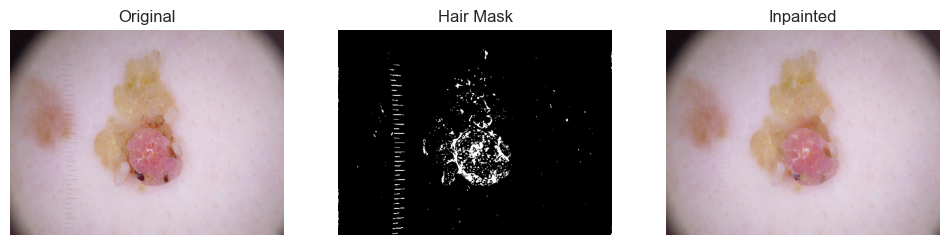

In [9]:
def dull_razor(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 9))
    blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, kernel)

    _, mask = cv2.threshold(blackhat, 10, 255, cv2.THRESH_BINARY)

    inpainted = cv2.inpaint(image, mask, 1, cv2.INPAINT_TELEA)

    return inpainted, mask


img = ds[10]["image"]
img_np = np.array(img)
img_bgr = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)

result, hair_mask = dull_razor(img_bgr)

result_rgb = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1); plt.title("Original"); plt.imshow(img_np); plt.axis('off')
plt.subplot(1, 3, 2); plt.title("Hair Mask"); plt.imshow(hair_mask, cmap='gray'); plt.axis('off')
plt.subplot(1, 3, 3); plt.title("Inpainted"); plt.imshow(result_rgb); plt.axis('off')
plt.show()


In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Get segmentation model, before that you need create directory models in root of the project and upload there unet_resnet34_segmentation.pth

In [11]:
model_seg = smp.Unet(encoder_name="resnet34", in_channels=3, classes=1)
state_dict_segm = torch.load("../models/unet_resnet34_segmentation.pth", map_location=device)
model_seg.load_state_dict(state_dict_segm)

<All keys matched successfully>

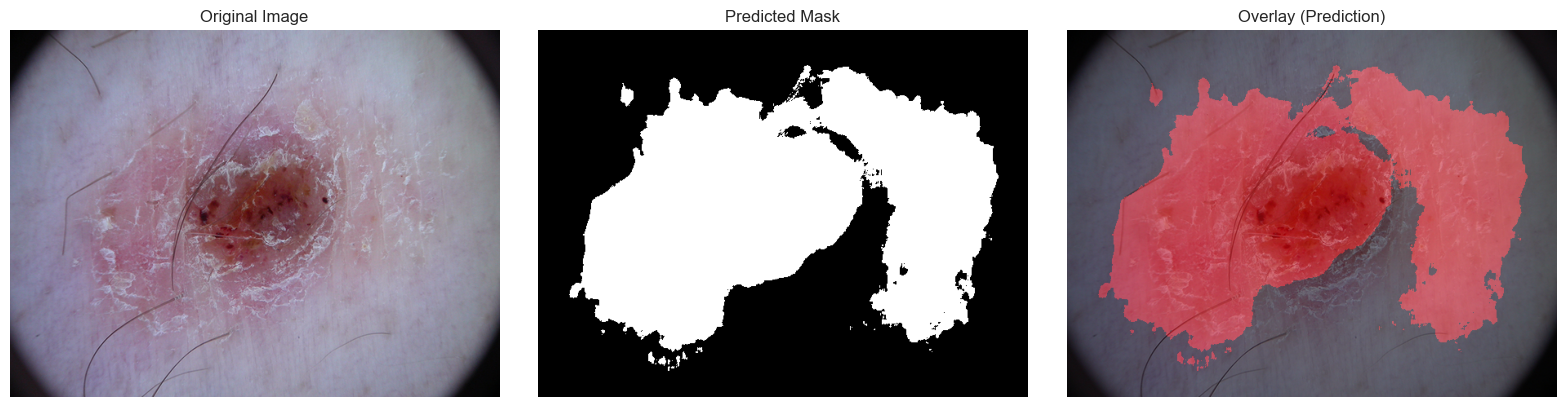

In [12]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_tensor, to_pil_image

model_seg.eval()

pil_image = ds[124]["image"]  # PIL.Image

input_tensor = to_tensor(pil_image).to(device).unsqueeze(0)

with torch.no_grad():
    output = model_seg(input_tensor)
    output = torch.sigmoid(output)
    pred_mask = output[0, 0].cpu().numpy()       # shape: (H, W)
    pred_mask_bin = (pred_mask > 0.3).astype(np.float32)

image_np = np.array(pil_image)

mask_rgb = np.zeros_like(image_np, dtype=np.uint8)
mask_rgb[..., 0] = (pred_mask_bin * 255).astype(np.uint8)

image_bgr = cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR)
mask_bgr  = cv2.cvtColor(mask_rgb,  cv2.COLOR_RGB2BGR)

alpha = 0.4
overlay_bgr = cv2.addWeighted(mask_bgr, alpha, image_bgr, 1 - alpha, 0)

overlay_rgb = cv2.cvtColor(overlay_bgr, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(16, 4))

plt.subplot(1, 3, 1)
plt.imshow(image_np)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(pred_mask_bin, cmap="gray")
plt.title("Predicted Mask")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(overlay_rgb)
plt.title("Overlay (Prediction)")
plt.axis("off")

plt.tight_layout()
plt.show()


Fine-Tuned Swin

In [13]:
from transformers import AutoModelForImageClassification, AutoImageProcessor

model = AutoModelForImageClassification.from_pretrained("kuchikihater/swin-skin-cancer")

/Users/kuchikihater/Downloads/skin_cancer_classification/.venv/lib/python3.11/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [14]:
label_map = {
    'akiec': 0,
    'bcc': 1,
    'bkl': 2,
    'df': 3,
    'mel': 4,
    'nv': 5,
    'vasc': 6
}

class ClearHair(torch.nn.Module):
    def forward(self, img):
        img_np = np.array(img)
        new_image, _ = dull_razor(img_np)
        return Image.fromarray(new_image)


class SegmentAndTransform:
    def __init__(self, seg_model, device, image_size=(224, 224)):
        self.seg_model = seg_model
        self.device = device
        self.image_size = image_size
        self.seg_model.eval()

    def __call__(self, img):
        img_resized = resize(to_tensor(img), self.image_size).unsqueeze(0).to(self.device)
        with torch.no_grad():
            output = self.seg_model(img_resized)
            mask = torch.sigmoid(output)[0, 0]
            mask_bin = (mask > 0.3).float()

        img_tensor = img_resized.squeeze(0) * mask_bin

        img_tensor = normalize(img_tensor,
                               mean=[0.485, 0.456, 0.406],
                               std=[0.229, 0.224, 0.225])

        return img_tensor


test_transforms = v2.Compose([
        ClearHair(),
        CenterCrop(450),
        v2.ToTensor(),
        Normalize(mean=[0.485, 0.456, 0.406],
                  std=[0.229, 0.224, 0.225])
])

/Users/kuchikihater/Downloads/skin_cancer_classification/.venv/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


Example of prediction

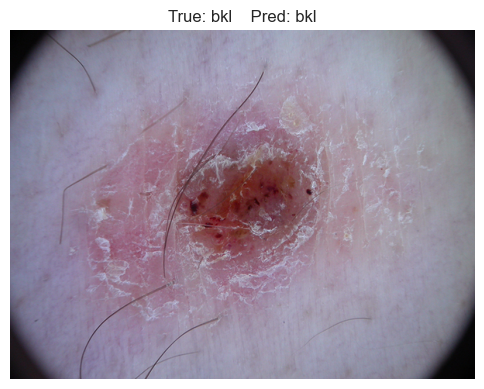

In [15]:
sample = ds[124]


img = sample["image"]
true_class_idx = sample["label"]
img_tensor = test_transforms(img).unsqueeze(0)  # [1, C, H, W]

model.eval()
with torch.no_grad():
    outputs = model(img_tensor)
    logits = outputs.logits
    predicted_class_idx = logits.argmax(-1).item()

pred_label_str = model.config.id2label[predicted_class_idx]
true_label_str = model.config.id2label[true_class_idx]

plt.figure(figsize=(6, 6))
plt.imshow(img)
plt.title(f"True: {true_label_str}    Pred: {pred_label_str}")
plt.axis("off")
plt.show()


GradCAM Inference

In [16]:
from pytorch_grad_cam.utils.image import show_cam_on_image, \
    preprocess_image


from pytorch_grad_cam import GradCAM

def reshape_transform(tensor):
    B, N, C = tensor.shape
    spatial = int(N ** 0.5)
    assert spatial * spatial == N, f"Expected square number of tokens, got {N}"
    result = tensor.reshape(B, spatial, spatial, C).permute(0, 3, 1, 2)
    print("After reshape:", result.shape)
    return result


import torch.nn as nn

class HuggingFaceWrapper(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
    def forward(self, x):
        return self.model(x).logits


target_layers = [model.swin.encoder.layers[3].blocks[1].output.dropout]

cam = GradCAM(model=HuggingFaceWrapper(model), target_layers=target_layers, reshape_transform=reshape_transform)




In [17]:
output = model(img_tensor)
class_idx = output.logits.argmax(dim=1).item()


In [18]:
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

grayscale_cam = cam(input_tensor=img_tensor, targets=[ClassifierOutputTarget(class_idx)])


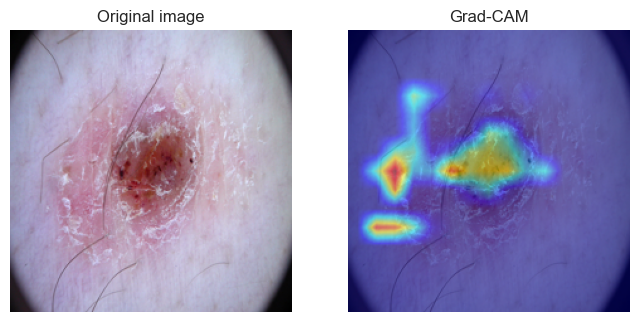

In [19]:
img_norm = np.array(img.resize((224, 224))) / 255.0
mn, mx = img_norm.min(), img_norm.max()
img_rescaled = (img_norm - mn) / (mx - mn)

cam_map = grayscale_cam[0]
cam_map = cv2.resize(cam_map, (224, 224), interpolation=cv2.INTER_LINEAR)

visualization = show_cam_on_image(img_rescaled, cam_map, use_rgb=True)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(img_rescaled)
plt.axis('off')
plt.title('Original image')
plt.subplot(1, 2, 2)
plt.imshow(visualization)
plt.axis('off')
plt.title('Grad-CAM')
plt.show()
